### Methodology
 Implementing the Noise2Void methodology of blind-spot networks for denoising. This involves performing a pre-processing step which identifies the 'active' pixels and then replaces their original noisy value with that of a neighbouring pixel. This processed data becomes the input to the neural network with the original noisy image being the network's target. However, unlike in most NN applications, the loss is not computed across the full predicted image, but only at the active pixel locations.

In [43]:
 
# Import necessary basic packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm 

# Import necessary torch packages
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

# Import our pre-made functions which will keep the notebook concise
# These functions are independent to the blindspot application however important for the data handling and 
# network creation/initialisation
from unet import UNet
from n2v_utils import regular_patching_2D, add_whitegaussian_noise, weights_init, set_seed, make_data_loader, plot_corruption, plot_training_metrics, plot_synth_results

In [44]:
cmap = 'viridis'

# For reproducibility purposes we set random numpy and torch seeds

##### Step 1 - Data Loading

In [45]:
import h5py
data = h5py.File(r'/home/sethi/self-supervised/infrared_pulses_3.h5','r')

d = data['data'][1000]

print(d.shape)

(176, 120)


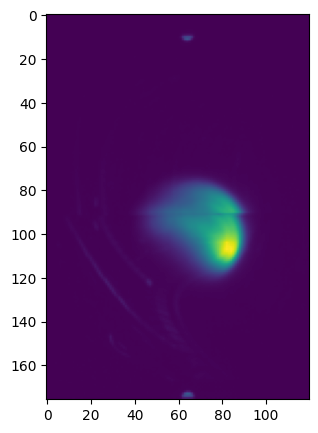

In [46]:
plt.figure(figsize=[7,5])
plt.imshow(d,cmap='viridis')

### Add noise

This is great for helping us benchmark the results however we are really interested in testing the denoising performance of blind-spot networks there we need to add some noise that we wish to later suppress.

In [47]:
noisydata, _ = add_whitegaussian_noise(d, sc=0.1)

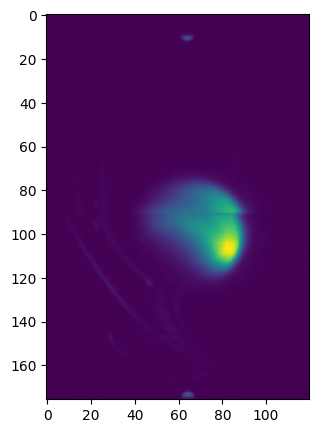

In [48]:

plt.figure(figsize=[7,5])
plt.imshow(noisydata, cmap=cmap)

### Patch Data

At the moment we have a single image that we wish to denoise however to train the network we need to give it multiple data examples. Therefore, following common computer vision methodology, we will select random patches from the data for the networks training.

Our patch implementation involves first regularly extracting patches from the image and then shuffling the patches such that they are in a random order. Later at the training stage these patches will be split into train and test dataset.

In [49]:
# Regularly extract patches from the noisy data
noisy_patches = regular_patching_2D(noisydata, 
                                    patchsize=[32, 32], # dimensions of extracted patch
                                    step=[4,6], # step to be taken in y,x for the extraction procedure
                                   )

# Randomise patch order
shuffler = np.random.permutation(len(noisy_patches))
noisy_patches = noisy_patches[shuffler] 

Extracting 540 patches


### Visualise the training patches

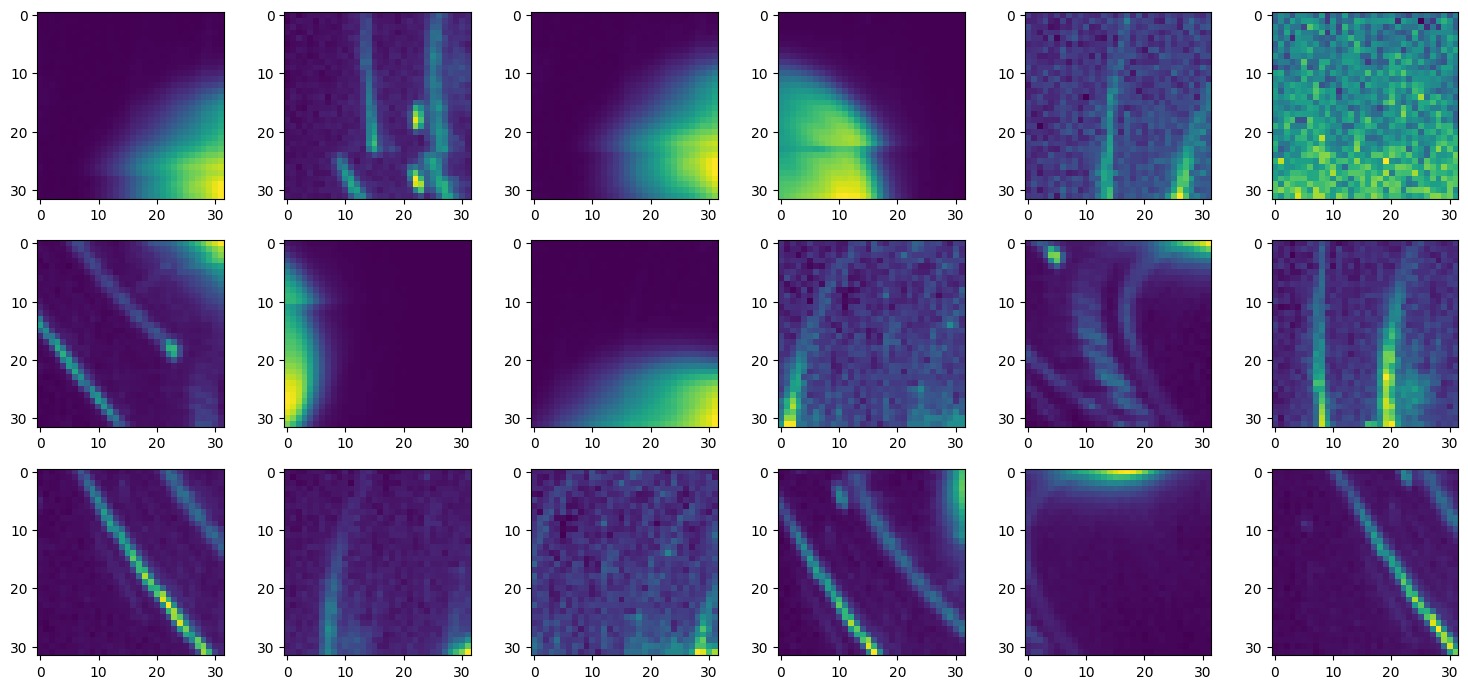

In [50]:
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap)
fig.tight_layout()


### Step 2 - Blind corruption of training data

Now we have made our noisy data into patches such that we have an adequate number to train the network, we now need to pre-process these noisy patches prior to being input into the network.

Implementation of the preprocessing involves:

- selecting the active pixels 
- selecting the neighbourhood pixel for each active pixel, which it will take the value of
- replacing each active pixels' value with its neighbourhood pixels' value
- creating a active pixel 'mask' which shows the location of the active pixels on the patch



The first three steps are important for the pre-processing of the noisy patches, whilst the fourth step is required for identifying the locations on which to compute the loss function during training.

##### Function that randomly selects and corrupts pixels following N2V methodology


In [51]:
def multi_active_pixels(patch, 
                        num_activepixels, 
                        neighbourhood_radius=5,
                       ):
    """ Function to identify multiple active pixels and replace with values from neighbouring pixels
    
    Parameters
    ----------
    patch : numpy 2D array
        Noisy patch of data to be processed
    num_activepixels : int
        Number of active pixels to be selected within the patch
    neighbourhood_radius : int
        Radius over which to select neighbouring pixels for active pixel value replacement
    Returns
    -------
        cp_ptch : numpy 2D array
            Processed patch 
        mask : numpy 2D array
            Mask showing location of active pixels within the patch 
    """

    n_rad = neighbourhood_radius  # descriptive variable name was a little long

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP ONE: SELECT ACTIVE PIXEL LOCATIONS
    idx_aps = np.random.randint(0, patch.shape[0], num_activepixels)
    idy_aps = np.random.randint(0, patch.shape[1], num_activepixels)
    id_aps = (idx_aps, idy_aps)
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP TWO: SELECT NEIGHBOURING PIXEL LOCATIONS
    
    # PART 1: Compute Shift
    # For each active pixel compute shift for finding neighbouring pixel and find pixel
    x_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    y_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    
    # OPTIONAL: don't allow replacement with itself
    for i in range(len(x_neigh_shft)):
        if x_neigh_shft[i] == 0 and y_neigh_shft[i] == 0:
            # This means its replacing itself with itself...
            shft_options = np.trim_zeros(np.arange(-n_rad // 2 + 1, n_rad // 2 + 1))
            x_neigh_shft[i] = np.random.choice(shft_options[shft_options != 0], 1)

    # PART 2: Find x and y locations of neighbours for the replacement
    idx_neigh = idx_aps + x_neigh_shft
    idy_neigh = idy_aps + y_neigh_shft    
    # Ensure neighbouring pixels within patch window
    idx_neigh = idx_neigh + (idx_neigh < 0) * patch.shape[0] - (idx_neigh >= patch.shape[0]) * patch.shape[0]
    idy_neigh = idy_neigh + (idy_neigh < 0) * patch.shape[1] - (idy_neigh >= patch.shape[1]) * patch.shape[1]
    # Get x,y of neighbouring pixels
    id_neigh = (idx_neigh, idy_neigh)
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP THREE: REPLACE ACTIVE PIXEL VALUES BY NEIGHBOURS
    cp_ptch = patch.copy()
    cp_ptch[id_aps] = patch[id_neigh]
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP FOUR: MAKE ACTIVE PIXEL MASK
    mask = np.ones_like(patch)
    mask[id_aps] = 0.

    return cp_ptch, mask

/tmp/ipykernel_46175/2467449092.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_neigh_shft[i] = np.random.choice(shft_options[shft_options != 0], 1)


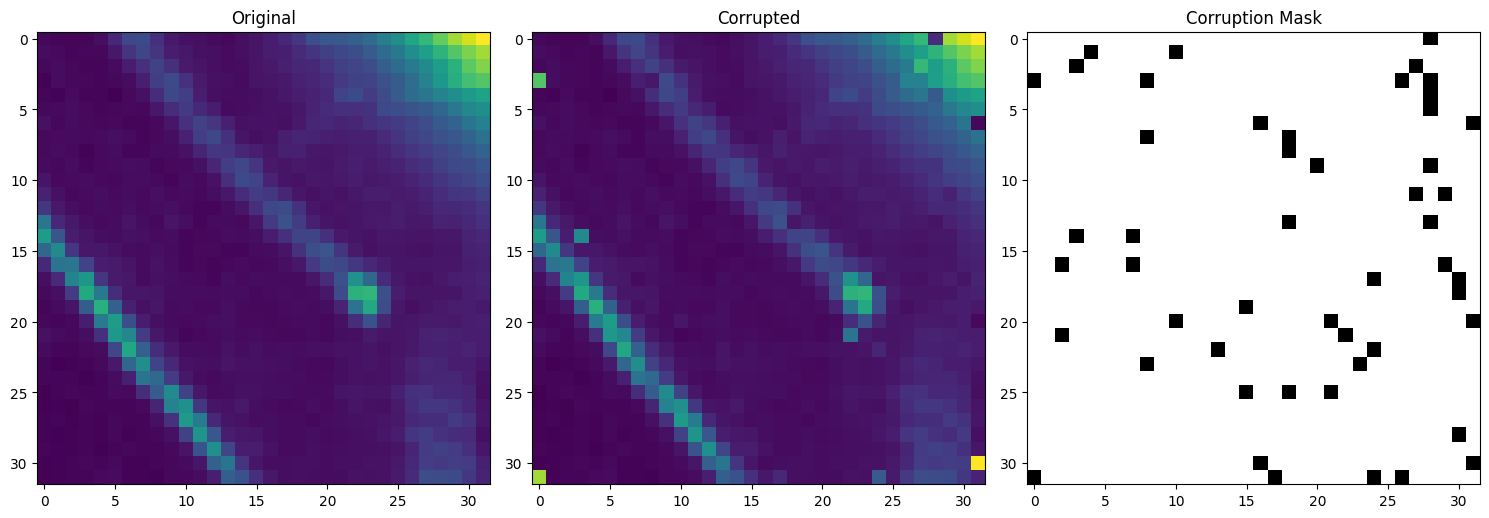

In [52]:
# Input the values of your choice into your pre-processing function
crpt_patch, mask = multi_active_pixels(noisy_patches[6], 
                                       num_activepixels=50, 
                                       neighbourhood_radius=5, 
                                      )

# Use the pre-made plotting function to visualise the corruption
fig,axs = plot_corruption(noisy_patches[6], crpt_patch, mask)

### SELECT THE NUMBER OF ACTIVE PIXELS (AS PERCENTAGE)
In the original N2V examples the authors use between 0.5 and 2% for the number of active pixels within a patch.

In Birnie et al., 2021 where they use this methodology for the suppression of white, Gaussian noise, the authors use 0.2%. However, in their example they have substantially more training patches.

Number of active pixels selected: 
 2.00 percent equals 20 pixels


/tmp/ipykernel_46175/2467449092.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_neigh_shft[i] = np.random.choice(shft_options[shft_options != 0], 1)


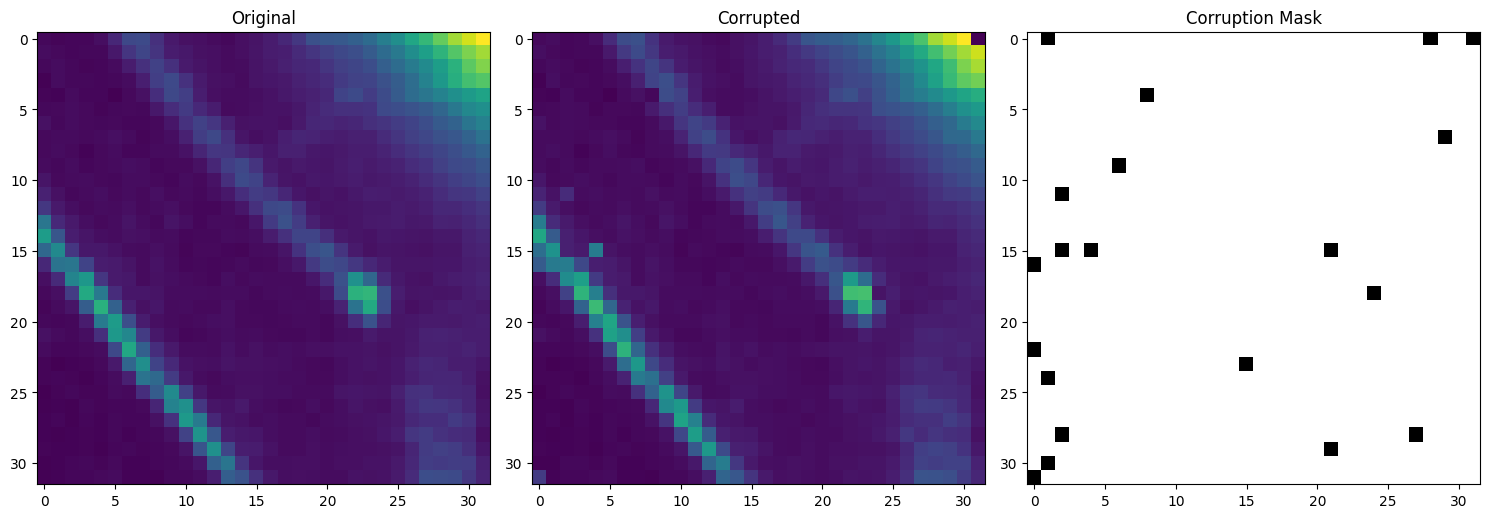

In [53]:
# Choose the percent of active pixels per patch
perc_active = 2

# Compute the total number of pixels within a patch
total_num_pixels = noisy_patches[0].shape[0]*noisy_patches[0].shape[1]
# Compute the number that should be active pixels based on the choosen percentage
num_activepixels = int(np.floor((total_num_pixels/100) * perc_active))
print("Number of active pixels selected: \n %.2f percent equals %i pixels"%(perc_active,num_activepixels))

# Input the values of your choice into your pre-processing function
crpt_patch, mask = multi_active_pixels(noisy_patches[6], 
                                       num_activepixels=num_activepixels, 
                                       neighbourhood_radius=5, 
                                      )

# Visulise the coverage of active pixels within a patch
fig,axs = plot_corruption(noisy_patches[6], crpt_patch, mask)

### Step 3 - Set up network 
In the N2V application of Krull et al., 2018, the network is not specially tailored to the blindspot task. As such, in theory any network could be used that goes from one input image to another of the same size.

In this case, like in Krull et al., 2018 , we will use a standard UNet architecture. As the architecture is independent to the blind-spot denoising procedure presented. 

In [54]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
else:
    print("No GPU available!")

Cuda installed! Running on GPU!
Device: cuda:0 Quadro RTX 4000


In [55]:
# Build UNet from pre-made function
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)
# Initialise UNet's weights from pre-made function
network = network.apply(weights_init) 

In [62]:
lr = 0.0001  # Learning rate
criterion = nn.MSELoss()  # Loss function
optim = torch.optim.Adam(network.parameters(), lr=lr)  # Optimiser

### Step 4 - Network Training
Now we have successfully built our network and prepared our data - by patching it to get adequate training samples and creating the input data by selecting and corrupting the active pixels. We are now ready to train the network.

Note - the network training is slightly different to standard image processing tasks in that we will only be computing the loss on the active pixels.

In [63]:
# Define training parameters
# Choose the number of epochs
n_epochs = 100  # most recommend 150-200 for random noise suppression 

# Choose number of training and validation samples
n_training = 500
n_test = 100

# Choose the batch size for the networks training
batch_size = 128

In [64]:
# Initialise arrays to keep track of train and validation metrics
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
test_accuracy_history = np.zeros(n_epochs)

# Create torch generator with fixed seed for reproducibility, to be used with the data loaders
g = torch.Generator()
g.manual_seed(0)

##### INCORPORATE LOSS FUNCTION INTO TRAINING PROCEDURE

In [65]:
def n2v_train(model, 
              criterion, 
              optimizer, 
              data_loader, 
              device):
    """ Blind-spot network training function
    
    Parameters
    ----------
    model : torch model
        Neural network
    criterion : torch criterion
        Loss function 
    optimizer : torch optimizer
        Network optimiser
    data_loader : torch dataloader
        Premade data loader with training data batches
    device : torch device
        Device where training will occur (e.g., CPU or GPU)
    
    Returns
    -------
        loss : float
            Training loss across full dataset (i.e., all batches)
        accuracy : float
            Training RMSE accuracy across full dataset (i.e., all batches) 
    """
    
    model.train()
    accuracy = 0  # initialise accuracy at zero for start of epoch
    loss = 0  # initialise loss at zero for start of epoch

    for dl in tqdm(data_loader):
        # Load batch of data from data loader 
        X, y, mask = dl[0].to(device), dl[1].to(device), dl[2].to(device)
        
        optimizer.zero_grad()
        
        # Predict the denoised image based on current network weights
        yprob = model(X)

        #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        # TO DO: Compute loss function only at masked locations and backpropogate it
        # (Hint: only two lines required)
        ls = criterion(yprob * (1 - mask), y * (1 - mask))
        ls.backward()        
        #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        
        
        optimizer.step()
        with torch.no_grad():
            yprob = yprob
            ypred = (yprob.detach().cpu().numpy()).astype(float)
            
        # Retain training metrics
        loss += ls.item()  
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))  
        
    # Divide cumulative training metrics by number of batches for training
    loss /= len(data_loader)  
    accuracy /= len(data_loader)  

    return loss, accuracy

##### Incorporate loss function into validation procedure

In [66]:
def n2v_evaluate(model,
                 criterion, 
                 optimizer, 
                 data_loader, 
                 device):
    """ Blind-spot network evaluation function
    
    Parameters
    ----------
    model : torch model
        Neural network
    criterion : torch criterion
        Loss function 
    optimizer : torch optimizer
        Network optimiser
    data_loader : torch dataloader
        Premade data loader with training data batches
    device : torch device
        Device where network computation will occur (e.g., CPU or GPU)
    
    Returns
    -------
        loss : float
            Validation loss across full dataset (i.e., all batches)
        accuracy : float
            Validation RMSE accuracy across full dataset (i.e., all batches) 
    """
    
    model.train()
    accuracy = 0  # initialise accuracy at zero for start of epoch
    loss = 0  # initialise loss at zero for start of epoch

    for dl in tqdm(data_loader):
        
        # Load batch of data from data loader 
        X, y, mask = dl[0].to(device), dl[1].to(device), dl[2].to(device)
        optimizer.zero_grad()
        
        yprob = model(X)

        with torch.no_grad():            
            #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
            # TO DO: Compute loss function only at masked locations 
            # (Hint: only one line required)
            ls = criterion(yprob * (1 - mask), y * (1 - mask))
            #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        
            ypred = (yprob.detach().cpu().numpy()).astype(float)
        
        # Retain training metrics
        loss += ls.item()  
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))  
        
    # Divide cumulative training metrics by number of batches for training
    loss /= len(data_loader)  
    accuracy /= len(data_loader)  

    return loss, accuracy

In [67]:
# TRAINING
for ep in range(n_epochs):  
        
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        
        # TO DO: USE ACTIVE PIXEL FUNCTION TO COMPUTE INPUT DATA AND MASKS
        # Hint: One line of code
        corrupted_patches[pi], masks[pi] = multi_active_pixels(noisy_patches[pi], 
                                                               num_activepixels=int(num_activepixels), 
                                                               neighbourhood_radius=5, 
                                                              )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # MAKE DATA LOADERS - using pre-made function 
    train_loader, test_loader = make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = batch_size,
                                                 torch_generator=g
                                                )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    # TO DO: Incorporate previously wrote n2v_train function
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)
    # Keeping track of training metrics
    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # EVALUATE (AKA VALIDATION)
    # TO DO: Incorporate previously wrote n2v_evaluate function
    test_loss, test_accuracy = n2v_evaluate(network, 
                                            criterion,
                                            optim,
                                            test_loader, 
                                            device,)
    # Keeping track of validation metrics
    test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # PRINTING TRAINING PROGRESS
    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, 
    Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')

/tmp/ipykernel_46175/2467449092.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_neigh_shft[i] = np.random.choice(shft_options[shft_options != 0], 1)
100%|██████████| 1/1 [00:00<00:00, 105.70it/s]


Epoch 0, 
    Training Loss 10688.7317,     Training Accuracy 720.2399, 
    Test Loss 8287.5439,     Test Accuracy 657.4910 


100%|██████████| 1/1 [00:00<00:00, 142.42it/s]


Epoch 1, 
    Training Loss 7296.6947,     Training Accuracy 595.8871, 
    Test Loss 4815.4092,     Test Accuracy 489.9238 


100%|██████████| 1/1 [00:00<00:00, 144.11it/s]


Epoch 2, 
    Training Loss 3431.7210,     Training Accuracy 404.7429, 
    Test Loss 1339.8528,     Test Accuracy 273.9923 


100%|██████████| 1/1 [00:00<00:00, 133.63it/s]


Epoch 3, 
    Training Loss 2035.8232,     Training Accuracy 311.9028, 
    Test Loss 2579.6648,     Test Accuracy 374.2662 


100%|██████████| 1/1 [00:00<00:00, 134.81it/s]


Epoch 4, 
    Training Loss 1528.3315,     Training Accuracy 299.1235, 
    Test Loss 1781.0170,     Test Accuracy 233.7591 


100%|██████████| 1/1 [00:00<00:00, 143.22it/s]


Epoch 5, 
    Training Loss 1121.0298,     Training Accuracy 242.1069, 
    Test Loss 1069.8142,     Test Accuracy 252.2217 


100%|██████████| 1/1 [00:00<00:00, 145.20it/s]


Epoch 6, 
    Training Loss 1213.7080,     Training Accuracy 252.9560, 
    Test Loss 850.0830,     Test Accuracy 224.1887 


100%|██████████| 1/1 [00:00<00:00, 143.13it/s]


Epoch 7, 
    Training Loss 1040.4352,     Training Accuracy 211.1145, 
    Test Loss 684.5222,     Test Accuracy 183.5392 


100%|██████████| 1/1 [00:00<00:00, 148.18it/s]


Epoch 8, 
    Training Loss 738.2136,     Training Accuracy 193.9580, 
    Test Loss 1141.6185,     Test Accuracy 190.4568 


100%|██████████| 1/1 [00:00<00:00, 146.25it/s]


Epoch 9, 
    Training Loss 578.7539,     Training Accuracy 180.5756, 
    Test Loss 394.0531,     Test Accuracy 154.3235 


100%|██████████| 1/1 [00:00<00:00, 129.09it/s]


Epoch 10, 
    Training Loss 638.3284,     Training Accuracy 165.7645, 
    Test Loss 649.6940,     Test Accuracy 151.4867 


100%|██████████| 1/1 [00:00<00:00, 128.23it/s]


Epoch 11, 
    Training Loss 512.6790,     Training Accuracy 154.1065, 
    Test Loss 306.7717,     Test Accuracy 134.5339 


100%|██████████| 1/1 [00:00<00:00, 118.55it/s]


Epoch 12, 
    Training Loss 452.2561,     Training Accuracy 145.3033, 
    Test Loss 718.4937,     Test Accuracy 127.9014 


100%|██████████| 1/1 [00:00<00:00, 108.03it/s]


Epoch 13, 
    Training Loss 302.9665,     Training Accuracy 129.5703, 
    Test Loss 188.9108,     Test Accuracy 118.6593 


100%|██████████| 1/1 [00:00<00:00, 130.34it/s]


Epoch 14, 
    Training Loss 354.7644,     Training Accuracy 119.9567, 
    Test Loss 396.4019,     Test Accuracy 107.3534 


100%|██████████| 1/1 [00:00<00:00, 139.78it/s]


Epoch 15, 
    Training Loss 238.9370,     Training Accuracy 108.9608, 
    Test Loss 132.4749,     Test Accuracy 96.1689 


100%|██████████| 1/1 [00:00<00:00, 123.16it/s]


Epoch 16, 
    Training Loss 220.6728,     Training Accuracy 100.0895, 
    Test Loss 143.9284,     Test Accuracy 89.2301 


100%|██████████| 1/1 [00:00<00:00, 149.58it/s]


Epoch 17, 
    Training Loss 197.1725,     Training Accuracy 92.8264, 
    Test Loss 52.9620,     Test Accuracy 81.8470 


100%|██████████| 1/1 [00:00<00:00, 149.29it/s]


Epoch 18, 
    Training Loss 184.6494,     Training Accuracy 85.3912, 
    Test Loss 156.8913,     Test Accuracy 78.5278 


100%|██████████| 1/1 [00:00<00:00, 141.42it/s]


Epoch 19, 
    Training Loss 148.8337,     Training Accuracy 80.2439, 
    Test Loss 132.9046,     Test Accuracy 73.7709 


100%|██████████| 1/1 [00:00<00:00, 146.58it/s]


Epoch 20, 
    Training Loss 125.7482,     Training Accuracy 75.2366, 
    Test Loss 58.3603,     Test Accuracy 70.8577 


100%|██████████| 1/1 [00:00<00:00, 147.77it/s]


Epoch 21, 
    Training Loss 115.8236,     Training Accuracy 71.3960, 
    Test Loss 60.7783,     Test Accuracy 67.5548 


100%|██████████| 1/1 [00:00<00:00, 147.78it/s]


Epoch 22, 
    Training Loss 88.1383,     Training Accuracy 68.9301, 
    Test Loss 250.0544,     Test Accuracy 67.3977 


100%|██████████| 1/1 [00:00<00:00, 149.36it/s]


Epoch 23, 
    Training Loss 81.9586,     Training Accuracy 67.3169, 
    Test Loss 104.4946,     Test Accuracy 64.7062 


100%|██████████| 1/1 [00:00<00:00, 101.27it/s]


Epoch 24, 
    Training Loss 112.8718,     Training Accuracy 65.9477, 
    Test Loss 82.6332,     Test Accuracy 61.8904 


100%|██████████| 1/1 [00:00<00:00, 144.97it/s]


Epoch 25, 
    Training Loss 71.4429,     Training Accuracy 64.1790, 
    Test Loss 116.7069,     Test Accuracy 60.8674 


100%|██████████| 1/1 [00:00<00:00, 148.06it/s]


Epoch 26, 
    Training Loss 82.1638,     Training Accuracy 62.5322, 
    Test Loss 51.8648,     Test Accuracy 58.0453 


100%|██████████| 1/1 [00:00<00:00, 151.32it/s]


Epoch 27, 
    Training Loss 78.9168,     Training Accuracy 60.9667, 
    Test Loss 46.2755,     Test Accuracy 56.5560 


100%|██████████| 1/1 [00:00<00:00, 152.94it/s]


Epoch 28, 
    Training Loss 72.4917,     Training Accuracy 60.5313, 
    Test Loss 61.0534,     Test Accuracy 56.3788 


100%|██████████| 1/1 [00:00<00:00, 148.19it/s]


Epoch 29, 
    Training Loss 99.9755,     Training Accuracy 59.3990, 
    Test Loss 40.8216,     Test Accuracy 53.0452 


100%|██████████| 1/1 [00:00<00:00, 147.01it/s]


Epoch 30, 
    Training Loss 80.4111,     Training Accuracy 58.4301, 
    Test Loss 33.3429,     Test Accuracy 52.1889 


100%|██████████| 1/1 [00:00<00:00, 149.58it/s]


Epoch 31, 
    Training Loss 95.4523,     Training Accuracy 56.7175, 
    Test Loss 118.5374,     Test Accuracy 51.9035 


100%|██████████| 1/1 [00:00<00:00, 142.98it/s]


Epoch 32, 
    Training Loss 68.7073,     Training Accuracy 55.5419, 
    Test Loss 39.9459,     Test Accuracy 49.7124 


100%|██████████| 1/1 [00:00<00:00, 149.61it/s]


Epoch 33, 
    Training Loss 65.3088,     Training Accuracy 54.4438, 
    Test Loss 52.4321,     Test Accuracy 48.6475 


100%|██████████| 1/1 [00:00<00:00, 139.68it/s]


Epoch 34, 
    Training Loss 52.1721,     Training Accuracy 53.5102, 
    Test Loss 71.4229,     Test Accuracy 48.8673 


100%|██████████| 1/1 [00:00<00:00, 148.68it/s]


Epoch 35, 
    Training Loss 84.9758,     Training Accuracy 53.2800, 
    Test Loss 63.8895,     Test Accuracy 47.2841 


100%|██████████| 1/1 [00:00<00:00, 147.67it/s]


Epoch 36, 
    Training Loss 59.8124,     Training Accuracy 51.9328, 
    Test Loss 54.8699,     Test Accuracy 47.9610 


100%|██████████| 1/1 [00:00<00:00, 148.55it/s]


Epoch 37, 
    Training Loss 72.8444,     Training Accuracy 51.6788, 
    Test Loss 27.8855,     Test Accuracy 47.7630 


100%|██████████| 1/1 [00:00<00:00, 150.02it/s]


Epoch 38, 
    Training Loss 67.4391,     Training Accuracy 51.6382, 
    Test Loss 74.4961,     Test Accuracy 46.4315 


100%|██████████| 1/1 [00:00<00:00, 152.29it/s]


Epoch 39, 
    Training Loss 62.2877,     Training Accuracy 50.0450, 
    Test Loss 110.8354,     Test Accuracy 44.7607 


100%|██████████| 1/1 [00:00<00:00, 148.99it/s]


Epoch 40, 
    Training Loss 48.2783,     Training Accuracy 49.1846, 
    Test Loss 76.7385,     Test Accuracy 47.2684 


100%|██████████| 1/1 [00:00<00:00, 152.85it/s]


Epoch 41, 
    Training Loss 43.0179,     Training Accuracy 49.7430, 
    Test Loss 61.0144,     Test Accuracy 44.6294 


100%|██████████| 1/1 [00:00<00:00, 153.08it/s]


Epoch 42, 
    Training Loss 65.8196,     Training Accuracy 47.9952, 
    Test Loss 21.9537,     Test Accuracy 42.5783 


100%|██████████| 1/1 [00:00<00:00, 150.95it/s]


Epoch 43, 
    Training Loss 44.0344,     Training Accuracy 47.0870, 
    Test Loss 44.0379,     Test Accuracy 42.7936 


100%|██████████| 1/1 [00:00<00:00, 136.12it/s]


Epoch 44, 
    Training Loss 71.0060,     Training Accuracy 47.0154, 
    Test Loss 19.2739,     Test Accuracy 41.8310 


100%|██████████| 1/1 [00:00<00:00, 147.29it/s]


Epoch 45, 
    Training Loss 52.5929,     Training Accuracy 46.2880, 
    Test Loss 26.2711,     Test Accuracy 40.6771 


100%|██████████| 1/1 [00:00<00:00, 140.13it/s]


Epoch 46, 
    Training Loss 38.8218,     Training Accuracy 45.7549, 
    Test Loss 155.6154,     Test Accuracy 41.5505 


100%|██████████| 1/1 [00:00<00:00, 146.23it/s]


Epoch 47, 
    Training Loss 35.9717,     Training Accuracy 44.9843, 
    Test Loss 30.5992,     Test Accuracy 38.8961 


100%|██████████| 1/1 [00:00<00:00, 135.80it/s]


Epoch 48, 
    Training Loss 67.6806,     Training Accuracy 45.1219, 
    Test Loss 28.6441,     Test Accuracy 38.7726 


100%|██████████| 1/1 [00:00<00:00, 145.93it/s]


Epoch 49, 
    Training Loss 41.2056,     Training Accuracy 45.3647, 
    Test Loss 17.5880,     Test Accuracy 40.4913 


100%|██████████| 1/1 [00:00<00:00, 144.36it/s]


Epoch 50, 
    Training Loss 45.7152,     Training Accuracy 44.6424, 
    Test Loss 20.7633,     Test Accuracy 40.1397 


100%|██████████| 1/1 [00:00<00:00, 145.71it/s]


Epoch 51, 
    Training Loss 41.8201,     Training Accuracy 44.3852, 
    Test Loss 40.0853,     Test Accuracy 39.8263 


100%|██████████| 1/1 [00:00<00:00, 146.31it/s]


Epoch 52, 
    Training Loss 44.6212,     Training Accuracy 43.7897, 
    Test Loss 27.9289,     Test Accuracy 39.7232 


100%|██████████| 1/1 [00:00<00:00, 146.89it/s]


Epoch 53, 
    Training Loss 48.5289,     Training Accuracy 43.7229, 
    Test Loss 15.4994,     Test Accuracy 38.4774 


100%|██████████| 1/1 [00:00<00:00, 145.78it/s]


Epoch 54, 
    Training Loss 47.0638,     Training Accuracy 43.8957, 
    Test Loss 19.5854,     Test Accuracy 40.0353 


100%|██████████| 1/1 [00:00<00:00, 147.05it/s]


Epoch 55, 
    Training Loss 46.1828,     Training Accuracy 43.8156, 
    Test Loss 23.0462,     Test Accuracy 38.6319 


100%|██████████| 1/1 [00:00<00:00, 145.19it/s]


Epoch 56, 
    Training Loss 40.0026,     Training Accuracy 42.1372, 
    Test Loss 57.4624,     Test Accuracy 38.1009 


100%|██████████| 1/1 [00:00<00:00, 142.53it/s]


Epoch 57, 
    Training Loss 48.5466,     Training Accuracy 43.4050, 
    Test Loss 18.1540,     Test Accuracy 36.7315 


100%|██████████| 1/1 [00:00<00:00, 145.32it/s]


Epoch 58, 
    Training Loss 27.0187,     Training Accuracy 42.3523, 
    Test Loss 28.9098,     Test Accuracy 37.2177 


100%|██████████| 1/1 [00:00<00:00, 151.80it/s]


Epoch 59, 
    Training Loss 37.9878,     Training Accuracy 41.1019, 
    Test Loss 43.1189,     Test Accuracy 36.3470 


100%|██████████| 1/1 [00:00<00:00, 145.06it/s]


Epoch 60, 
    Training Loss 44.2899,     Training Accuracy 41.2054, 
    Test Loss 24.4873,     Test Accuracy 36.7406 


100%|██████████| 1/1 [00:00<00:00, 146.91it/s]


Epoch 61, 
    Training Loss 32.1180,     Training Accuracy 40.6611, 
    Test Loss 43.5180,     Test Accuracy 37.3226 


100%|██████████| 1/1 [00:00<00:00, 146.02it/s]


Epoch 62, 
    Training Loss 29.2674,     Training Accuracy 40.5702, 
    Test Loss 14.2537,     Test Accuracy 35.3899 


100%|██████████| 1/1 [00:00<00:00, 145.44it/s]


Epoch 63, 
    Training Loss 55.1210,     Training Accuracy 40.6531, 
    Test Loss 20.9663,     Test Accuracy 36.4050 


100%|██████████| 1/1 [00:00<00:00, 145.20it/s]


Epoch 64, 
    Training Loss 34.5164,     Training Accuracy 41.2812, 
    Test Loss 21.8262,     Test Accuracy 36.4510 


100%|██████████| 1/1 [00:00<00:00, 142.83it/s]


Epoch 65, 
    Training Loss 28.2836,     Training Accuracy 41.9920, 
    Test Loss 18.5992,     Test Accuracy 34.3619 


100%|██████████| 1/1 [00:00<00:00, 143.70it/s]


Epoch 66, 
    Training Loss 27.1724,     Training Accuracy 40.6636, 
    Test Loss 40.0518,     Test Accuracy 43.2988 


100%|██████████| 1/1 [00:00<00:00, 146.70it/s]


Epoch 67, 
    Training Loss 39.9846,     Training Accuracy 42.8609, 
    Test Loss 22.2066,     Test Accuracy 35.4894 


100%|██████████| 1/1 [00:00<00:00, 144.15it/s]


Epoch 68, 
    Training Loss 28.1877,     Training Accuracy 40.3037, 
    Test Loss 29.2653,     Test Accuracy 36.8222 


100%|██████████| 1/1 [00:00<00:00, 145.08it/s]


Epoch 69, 
    Training Loss 38.7227,     Training Accuracy 41.5773, 
    Test Loss 31.0574,     Test Accuracy 42.8666 


100%|██████████| 1/1 [00:00<00:00, 143.88it/s]


Epoch 70, 
    Training Loss 33.7540,     Training Accuracy 42.2051, 
    Test Loss 37.6638,     Test Accuracy 35.3684 


100%|██████████| 1/1 [00:00<00:00, 143.94it/s]


Epoch 71, 
    Training Loss 31.9152,     Training Accuracy 40.1864, 
    Test Loss 19.8442,     Test Accuracy 33.2040 


100%|██████████| 1/1 [00:00<00:00, 145.35it/s]


Epoch 72, 
    Training Loss 32.2048,     Training Accuracy 39.3805, 
    Test Loss 18.8593,     Test Accuracy 34.1813 


100%|██████████| 1/1 [00:00<00:00, 145.18it/s]


Epoch 73, 
    Training Loss 35.0194,     Training Accuracy 38.8063, 
    Test Loss 18.1542,     Test Accuracy 33.6979 


100%|██████████| 1/1 [00:00<00:00, 141.93it/s]


Epoch 74, 
    Training Loss 49.5637,     Training Accuracy 39.9889, 
    Test Loss 27.7997,     Test Accuracy 32.6435 


100%|██████████| 1/1 [00:00<00:00, 144.07it/s]


Epoch 75, 
    Training Loss 25.9929,     Training Accuracy 38.1697, 
    Test Loss 12.8335,     Test Accuracy 34.5692 


100%|██████████| 1/1 [00:00<00:00, 144.54it/s]


Epoch 76, 
    Training Loss 34.5285,     Training Accuracy 37.9734, 
    Test Loss 18.6343,     Test Accuracy 33.1750 


100%|██████████| 1/1 [00:00<00:00, 146.68it/s]


Epoch 77, 
    Training Loss 36.8332,     Training Accuracy 37.3835, 
    Test Loss 19.9276,     Test Accuracy 32.7843 


100%|██████████| 1/1 [00:00<00:00, 143.39it/s]


Epoch 78, 
    Training Loss 27.7923,     Training Accuracy 37.1248, 
    Test Loss 28.3707,     Test Accuracy 32.0211 


100%|██████████| 1/1 [00:00<00:00, 143.27it/s]


Epoch 79, 
    Training Loss 22.0167,     Training Accuracy 36.3814, 
    Test Loss 23.4673,     Test Accuracy 33.0792 


100%|██████████| 1/1 [00:00<00:00, 143.08it/s]


Epoch 80, 
    Training Loss 24.3136,     Training Accuracy 36.5029, 
    Test Loss 14.8811,     Test Accuracy 32.4632 


100%|██████████| 1/1 [00:00<00:00, 144.63it/s]


Epoch 81, 
    Training Loss 33.1692,     Training Accuracy 37.2926, 
    Test Loss 27.6273,     Test Accuracy 33.3736 


100%|██████████| 1/1 [00:00<00:00, 142.81it/s]


Epoch 82, 
    Training Loss 23.8263,     Training Accuracy 36.6421, 
    Test Loss 30.6052,     Test Accuracy 33.3367 


100%|██████████| 1/1 [00:00<00:00, 144.49it/s]


Epoch 83, 
    Training Loss 32.1372,     Training Accuracy 37.8707, 
    Test Loss 19.4654,     Test Accuracy 33.5083 


100%|██████████| 1/1 [00:00<00:00, 147.50it/s]


Epoch 84, 
    Training Loss 25.1062,     Training Accuracy 40.2063, 
    Test Loss 17.0339,     Test Accuracy 34.5030 


100%|██████████| 1/1 [00:00<00:00, 147.72it/s]


Epoch 85, 
    Training Loss 31.0627,     Training Accuracy 38.7215, 
    Test Loss 25.9309,     Test Accuracy 37.0895 


100%|██████████| 1/1 [00:00<00:00, 144.20it/s]


Epoch 86, 
    Training Loss 37.1115,     Training Accuracy 38.1790, 
    Test Loss 18.0967,     Test Accuracy 31.4974 


100%|██████████| 1/1 [00:00<00:00, 145.99it/s]


Epoch 87, 
    Training Loss 32.0807,     Training Accuracy 38.0601, 
    Test Loss 31.1229,     Test Accuracy 41.8038 


100%|██████████| 1/1 [00:00<00:00, 144.43it/s]


Epoch 88, 
    Training Loss 42.5144,     Training Accuracy 40.9844, 
    Test Loss 30.8460,     Test Accuracy 37.2028 


100%|██████████| 1/1 [00:00<00:00, 143.00it/s]


Epoch 89, 
    Training Loss 32.9775,     Training Accuracy 39.2984, 
    Test Loss 25.0568,     Test Accuracy 35.6874 


100%|██████████| 1/1 [00:00<00:00, 145.49it/s]


Epoch 90, 
    Training Loss 29.5605,     Training Accuracy 38.3270, 
    Test Loss 49.0998,     Test Accuracy 35.0781 


100%|██████████| 1/1 [00:00<00:00, 145.96it/s]


Epoch 91, 
    Training Loss 34.3006,     Training Accuracy 38.2993, 
    Test Loss 25.2325,     Test Accuracy 30.6742 


100%|██████████| 1/1 [00:00<00:00, 141.63it/s]


Epoch 92, 
    Training Loss 28.4749,     Training Accuracy 36.5578, 
    Test Loss 39.6252,     Test Accuracy 43.7517 


100%|██████████| 1/1 [00:00<00:00, 145.69it/s]


Epoch 93, 
    Training Loss 36.5539,     Training Accuracy 41.1089, 
    Test Loss 10.7747,     Test Accuracy 33.4217 


100%|██████████| 1/1 [00:00<00:00, 143.95it/s]


Epoch 94, 
    Training Loss 25.2034,     Training Accuracy 37.1112, 
    Test Loss 17.4144,     Test Accuracy 34.8611 


100%|██████████| 1/1 [00:00<00:00, 143.77it/s]


Epoch 95, 
    Training Loss 32.1943,     Training Accuracy 37.2258, 
    Test Loss 18.6257,     Test Accuracy 31.0045 


100%|██████████| 1/1 [00:00<00:00, 146.37it/s]


Epoch 96, 
    Training Loss 24.1262,     Training Accuracy 35.5119, 
    Test Loss 12.4965,     Test Accuracy 32.2214 


100%|██████████| 1/1 [00:00<00:00, 148.70it/s]


Epoch 97, 
    Training Loss 31.6891,     Training Accuracy 35.7062, 
    Test Loss 9.4160,     Test Accuracy 30.3406 


100%|██████████| 1/1 [00:00<00:00, 147.01it/s]


Epoch 98, 
    Training Loss 27.1068,     Training Accuracy 35.3072, 
    Test Loss 22.5630,     Test Accuracy 31.9555 


100%|██████████| 1/1 [00:00<00:00, 147.40it/s]

Epoch 99, 
    Training Loss 22.9646,     Training Accuracy 34.6292, 
    Test Loss 17.2644,     Test Accuracy 30.9625 


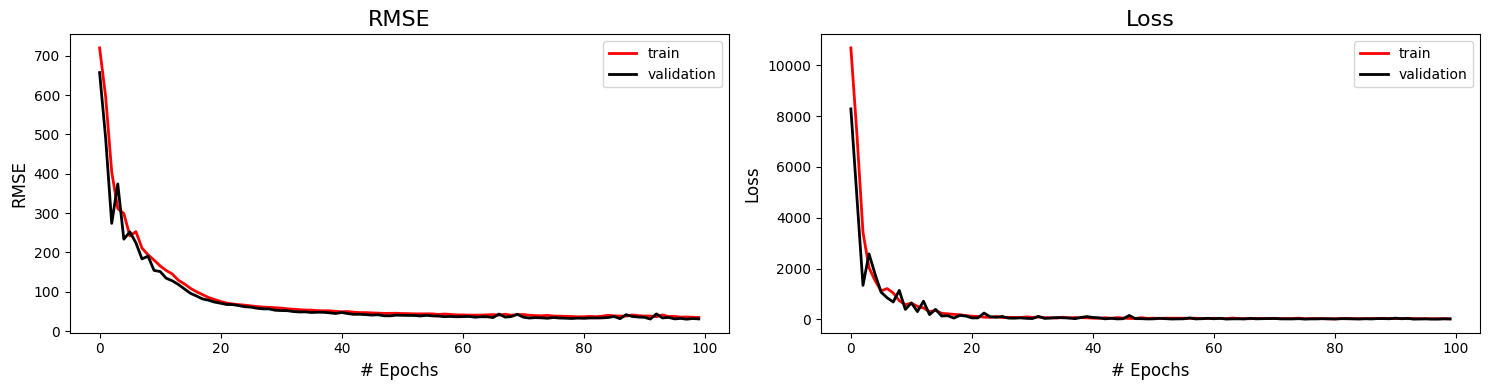

In [68]:
# Plotting trainnig metrics using pre-made function
fig,axs = plot_training_metrics(train_accuracy_history,
                                test_accuracy_history,
                                train_loss_history,
                                test_loss_history
                               )

### Step 5 - Apply trained model
The model is now trained and ready for its denoising capabilities to be tested.

For the standard network application, the noisy image does not require any data patching nor does it require the active pixel pre-processing required in training. In other words, the noisy image can be fed directly into the network for denoising.

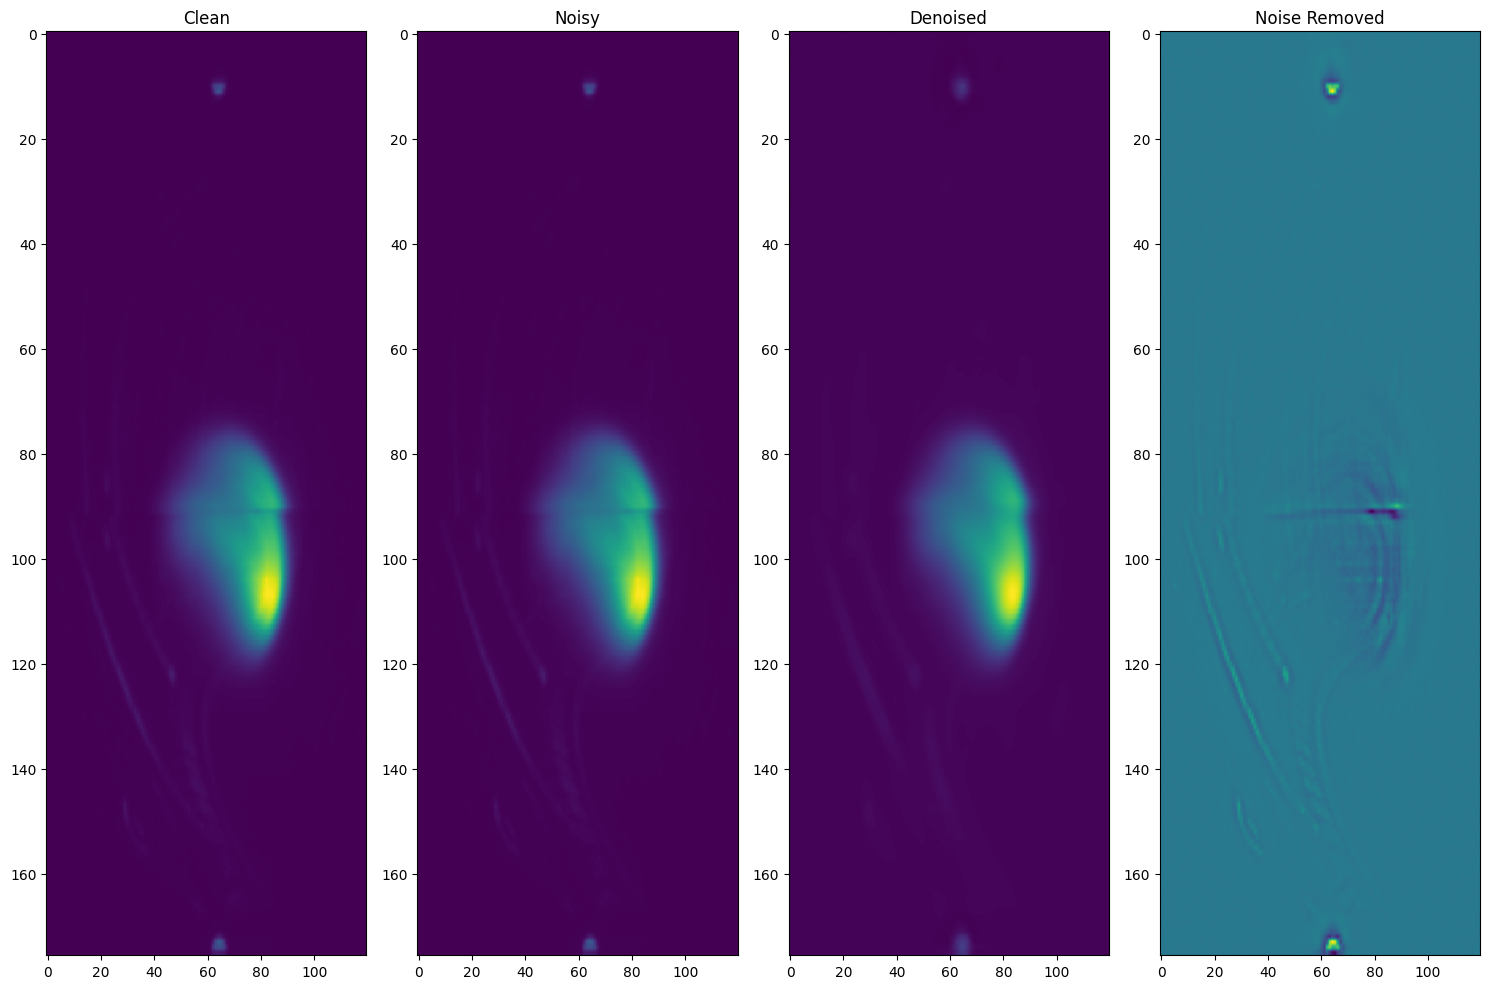

In [69]:
### Denoise New Noisy Dataset
# Make a new noisy realisation so it's different from the training set but with roughly same level of noise
testdata, _ = add_whitegaussian_noise(d, sc=0.1)

# Convert dataset in tensor for prediction purposes
torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(testdata,axis=0),axis=0)).float()

# Run test dataset through network
network.eval()
test_prediction = network(torch_testdata.to(device))

# Return to numpy for plotting purposes
test_pred = test_prediction.detach().cpu().numpy().squeeze()

# Use pre-made plotting function to visualise denoising performance
fig,axs = plot_synth_results(d, testdata, test_pred)